In [17]:
import numpy as np
from scipy.special import comb
import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple

# Analysis of Project

Below is some classes and functions setting everything up:
* We have a class `ProblemInstance` representing an instance of the problem
* A function `gen_problem` that generates a problem instance
* Two distributions, `uniform_distribution` and `bad_distribution`



In [2]:
# an instance of a problem
class ProblemInstance():
    
    def __init__(self, num_vertices, num_experts, correctness, expert_opinions, bot_locations):
        self.num_vertices = num_vertices
        self.num_experts = num_experts
        self.correctness = correctness
        self.expert_opinions = expert_opinions
        self.bot_locations = bot_locations
    
    # get a random untested loc
    def next_loc(self, tested_locs):
        verts = set(range(0, self.num_vertices))
        tested_locs = set(tested_locs)
        remaining = np.asarray(list(verts - tested_locs))
        if len(remaining) == 0:
            raise ValueError('cannot sample next loc!')
        return np.random.choice(remaining)
        
    def __repr__(self):
        locs = ' '.join([str(x) for x in self.bot_locations])
        ops = '\n'
        for i in range(self.num_experts):
            ops += '{:.2f} '.format(self.correctness[i])
            ops += ''.join(['Y' if x else 'N' for x in self.expert_opinions[i]])
            ops += '\n'
        s = 'PI({}, {}, [{}], {})'.format(self.num_vertices, self.num_experts, locs, ops)
        return s
        
def uniform_distribution():
    return np.random.uniform(0.5, 1)

def bad_distribution():
    return np.random.uniform(0.5, 0.8)

def beta_distribution():
    return 1 - np.random.beta(4, 2)/2
        
def gen_problem(n=100, k=10, student_correctness=uniform_distribution):
    bot_locations = np.random.choice(100, 5, replace=False)
    expert_opinions = {}
    correctness = {}
    for i in range(k):
        # get student correctness
        alpha = student_correctness()
        correctness[i] = alpha
        num_vertices_correct = int(alpha * n)
        # sample the correct locations
        correct_locations = np.random.choice(n, num_vertices_correct, replace=False)
        
        # build the student opinions
        opinions = []
        for j in range(n):
            b = (j in bot_locations)
            if j in correct_locations:
                opinions.append(b)
            else:
                opinions.append(not b)
        expert_opinions[i] = opinions
        
    return ProblemInstance(n, k, correctness, expert_opinions, bot_locations)

# Implementing Multiplicative weights

* The `most_likely` function takes an instance and the expert opinions, along with weights assigned to each experts, and sorts the untested locations in descending order of which is most likely
* `multiplicative_weights` implements running multiplicative weights with all student opinions, and constantly picking the next most confident vertex based on weight.
* `random_sampling` implements a strategy that looks at vertices in random order, just as a counter-balance

In [3]:
# using the given weights vector, find the most confident locations
def most_likely(p, weights, tested_locs):
    confidences = []
    for loc in range(p.num_vertices):
        if loc not in tested_locs:
            confidence = 0
            for i in range(p.num_experts):
                if p.expert_opinions[i][loc]:
                    confidence += weights[i]
            confidences.append((loc, confidence))
    confidences = sorted(confidences, key= lambda x: -x[1])
#     print(confidences)
    return [k[0] for k in confidences]

# run multiplicative weights on p with value eps, to discover bots as quickly as possible
def multiplicative_weights(p, eps=0.5):
    k = p.num_experts
    discovered_locs = []
    tested_locs = []
    weights = np.repeat(1.0, k)
    
    while len(discovered_locs) < len(p.bot_locations):
#         print(weights)
        loc = most_likely(p, weights, tested_locs)[0]
        has_bot = loc in p.bot_locations
        for i in range(k):
            if has_bot != p.expert_opinions[i][loc]:
                # weight update!
                weights[i] = weights[i] * (1 - eps)
        if has_bot:
            discovered_locs.append(loc)
        tested_locs.append(loc)
    
    return len(tested_locs)

# completely random sampler
def random_sampling(p):
    # sample a random order
    order = np.random.choice(p.num_vertices, p.num_vertices, replace=False)
    discovered_locs = []
    tested_locs = 0
    while len(discovered_locs) < len(p.bot_locations):
        if order[tested_locs] in p.bot_locations:
            discovered_locs.append(order[tested_locs])
        tested_locs += 1
    return tested_locs

def majority_vote(p):
    k = p.num_experts
    weights = np.repeat(1.0, k)
    order = most_likely(p, weights, [])
    discovered_locs = []
    tested_locs = 0
    while len(discovered_locs) < len(p.bot_locations):
        if order[tested_locs] in p.bot_locations:
            discovered_locs.append(order[tested_locs])
        tested_locs += 1
    return tested_locs

# Input Generation

This is kept deterministic with the seed. We generate 1000 random inputs with student correctness as $\alpha \sim [0.5, 1]$, and then also with $\alpha \sim (1 - \beta(4, 2))$ as in the project inputs.

In [4]:
def gen_problems(no=1000, correctness=uniform_distribution):
    np.random.seed(171)
    problems = []
    for i in range(no):
        problems.append(gen_problem(student_correctness=correctness))
    return problems

In [5]:
# WARNING: this cell takes a long time to run
unif_dataset = gen_problems(correctness=uniform_distribution)
beta_dataset = gen_problems(correctness=beta_distribution)

# Evaluation/Hyperparameter Tuning

Fold evaluation and hyperparameter tuning of $\epsilon$ for MW into one. This is not strictly speaking _good practice_, but it gives us a good idea of what epsilon to use for MW.

First, we evaluate using the uniform dataset.

In [6]:
def eval_mw(eps, dataset):
    N = len(dataset)
    data = np.zeros((len(eps), N), dtype=int)
    for i in range(N):
        p = dataset[i]
        for j in range(len(eps)):
            data[j][i] = multiplicative_weights(p, eps[j])
    return data

def eval_fixed(dataset, strategy):
    N = len(dataset)
    data = np.zeros(N, dtype=int)
    for i in range(N):
        data[i] = strategy(dataset[i])
    return data

eps = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [7]:
# WARNING: this cell takes a long time to run
unif_dataset_mw_results = eval_mw(eps, unif_dataset)

# Hyperparameter tuning of $\epsilon$ for MW

We first plot the expected time to find all the bots as a function of $\epsilon$, to see what the best value is. Appears to be $\epsilon \approx 0.4$, although really anything that actually uses expert opinions does pretty well because the experts are so good here.

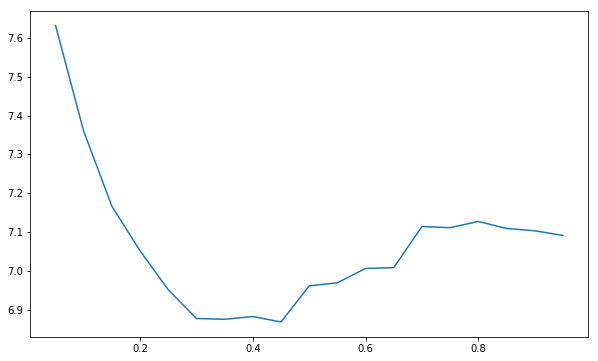

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(eps, np.mean(unif_dataset_mw_results, axis=1))
plt.show()

And just to observe, the distribution is really concentrated around 5. Because the experts are so good, we almost immediately find the bots, because our first few choices work almost all the time and we quickly discover who isn't good, making the remaining choices almost perfect. As a sanity check, we can see that $\epsilon=0.15$ performs marginally worse.

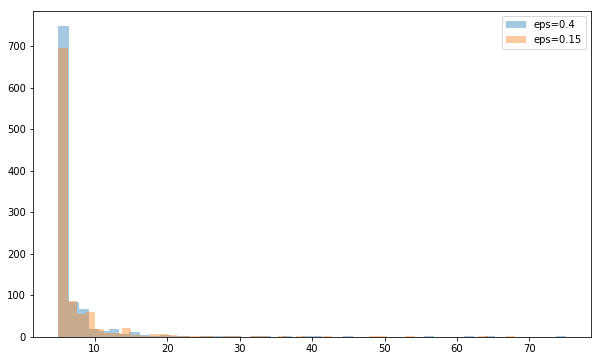

In [9]:
plt.figure(figsize=(10, 6))
for i in [7, 2]:
    plt.hist(unif_dataset_mw_results[i], bins=50, label='eps={}'.format(eps[i]), alpha=0.4)
plt.legend(loc='upper right')
plt.show()

# What is our beta distribution?

Let's look at the distribution of correctness as it was done on the project. We can see that it's heavily biased towards incorrect students, unlike the uniform distribution. This means that in general, really good students are very rare. Let's see what happens with this dataset.

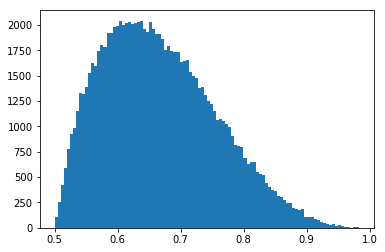

In [334]:
b = 1 - (np.random.beta(4, 2, 100000))/2
# plt.figure(figsize=(10, 6))
plt.hist(b, bins=100)
plt.show()

In [11]:
# WARNING: this cell takes a REALLY LONG while to run
beta_dataset_mw_results = eval_mw(eps, beta_dataset)

In [12]:
beta_dataset_random_results = eval_fixed(beta_dataset, random_sampling)
beta_dataset_mv_results = eval_fixed(beta_dataset, majority_vote)

There's a clear winner in terms of performance with $\epsilon \approx 0.15$.

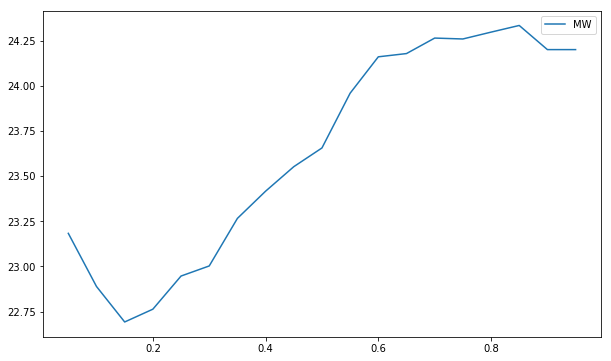

In [216]:
plt.figure(figsize=(10, 6))
plt.plot(eps, np.mean(beta_dataset_mw_results, axis=1), label='MW')
plt.legend()
plt.show()

And as we can see, it's significantly harder to find the bots now. There's still many instances where we can do it in under 20 tries, but they are much less frequent than with the uniform distribution. As another sanity check, we compare with a completely random strategy, which ends up doing exteremely poorly (because we need to find all the bots, in expectation the maximum of their locations in a random order will be quite large). If we compare with the majority vote strategy, then we see that MW also performs better than ignoring student correctness.

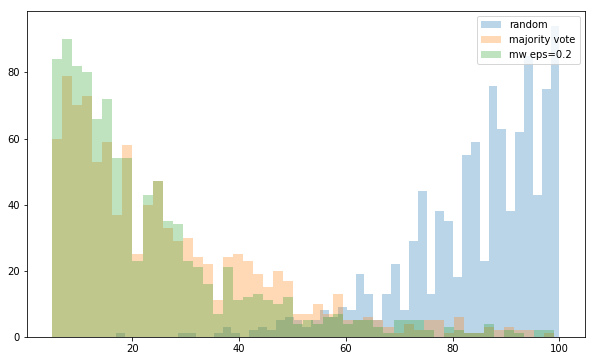

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(beta_dataset_random_results, bins=50, label='random'.format(eps[i]), alpha=0.3)
plt.hist(beta_dataset_mv_results, bins=50, label='majority vote'.format(eps[i]), alpha=0.3)
for i in [3]:
    plt.hist(beta_dataset_mw_results[i], bins=50, label='mw eps={}'.format(eps[i]), alpha=0.3)
plt.legend(loc='upper right')
plt.show()

# Comparing with a Model-Based Solver

The big question, really, is how well MW performs compared to a model that does the probabalistic "best choice" in terms of students, if we know the distribution of student correctness as a prior.

Assume we have a graph with $N$ vertices, and a student that is correct on $K$ of them. We observe that on our $n$-size sample, that the student has been correct on $k$ of those. What is the probability of this happening? Well, this is the probability that a randomly chosen $n$-size subset has a size-k intersection with $K$. Let $S_{k, n}$ denote the event that a student is correct on $k$ of the first $n$ vertices in our sample, and $O_{K, N}$ the event that a student is correct on $K$ of $N$ vertices overall:

$$p(S_{k, n} \mid O_{K, N}) = \frac{{K \choose k} {N - K \choose n - k}}{N \choose n}$$

Let's precompute these values for $N = 100$.

In [286]:
N = 100

def compute_p_skn_given_okn(K, n, k):
    if k > K or k > n:
        # it's impossible for us to be correct on more than n vertices so far,
        # or correct on more than K vertices
        return 0
    return comb(K, k, exact=True) * comb(N - K, n- k, exact=True) / comb(N, n, exact=True)

p_skn_given_okn = np.zeros((101, 101, 101), dtype=np.dtype('f16'))

In [287]:
# takes a while to run
for K in range(0, N+1):
    for n in range(0, N+1):
        for k in range(0, n+1):
            p_skn_given_okn[K, n, k] = compute_p_skn_given_okn(K, n, k)

In [288]:
p_skn_given_okn[70, 20, 12], p_skn_given_okn[70, 20, 14], p_skn_given_okn[70, 20, 16]

(0.11617645704296757081, 0.21409106297884658576, 0.12680778345670143392)

Now, let's say the student has been observed to be correct on $k$ of $n$ vertices so far, and they are correct in total on $K$ of $N$ vertices. What's the probability they will be correct on the next vertex? Well, this is just the number of "correct" vertices we pick, divided by the number of vertices we haven't picked yet:

$$p(C \mid S_{k, n}, O_{K, N}) = \max\left(0, \frac{K - k}{N - n}\right)$$

Our next step is to eliminate the event $O_{K, N}$, because we don't know it _a priori_. However, we do know the distribution based on the fact that we sample student correctness from the uniform distribution:

$$p(O_{K, 100}) = \begin{cases}
    \frac{1}{51} & \text{if } 50 \leq K \leq 100 \\
    0 & \text{otherwise }
\end{cases}$$

Now we have a way to estimate $p(C \mid S_{k, n})$, which is what we want. We can use the total probability rule:

$$p(C \mid S_{k, n}) = \sum_{\tilde{K} = 0}^{100} p(C \mid S_{k, n}, O_{\tilde{K}, N}) p(O_{\tilde{K}, N} \mid S_{k, n})$$

We don't know $p(O_{{\tilde K}, N} \mid S_{k, n})$, but we can flip the direction using Bayes' rule:

$$p(O_{\tilde{K}, N} \mid S_{k, n}) = \frac{p(S_{k, n} \mid O_{\tilde{K}, N}) p(O_{\tilde{K}, N})}{\sum_{K' = 0}^{100} p(S_{k, n} \mid O_{K', N}) p(O_{K', N})}$$

We can fold this into the original rule for computing $p(C \mid S_{k, n})$:

$$p(C \mid S_{k, n}) = \frac{\sum_{{\tilde K} = 0}^{100} p(C \mid S_{k, n}, O_{{\tilde K}, N}) p(S_{k, n} \mid O_{{\tilde K}, N}) p(O_{{\tilde K}, N})}{\sum_{K' = 0}^{100} p(S_{k, n} \mid O_{K', N}) p(O_{K', N})}$$

Let's also precompute the values for $p(C \mid S_{k, n})$.

In [401]:
def uniform_on_K(K):
#     return 1/101
    if 50 <= K <= 100:
        return 1/50
    else:
        return 0
    
def full_uniform_on_K(K):
    return 1/101

def compute_p_C_given_skn_okn(K, k, n):
    return max(0, (K - k)/(N-n))

def compute_p_C_given_skn(k, n, K_dist):
    top_frac = 0
    bottom_frac = 0
    for K in range(0, 101):
        bf = p_skn_given_okn[K, n, k] * K_dist(K)
        top_frac += compute_C_given_skn_okn(K, k, n) * bf
        bottom_frac += bf
    if bottom_frac == 0.0:
        return 0.0
    return top_frac / bottom_frac

def compute_all_p_C_given_skn(K_dist):
    p_C_given_skn = np.zeros((101, 101))
    for n in range(0, N):
        for k in range(0, n+1):
            p_C_given_skn[n, k] = compute_p_C_given_skn(k, n, K_dist)
    return p_C_given_skn

In [403]:
p_C_given_skn = compute_all_p_C_given_skn(uniform_on_K)

Below, we plot the computed correctness probability of students in different situations. The x-axis is the fraction of locations reported correctly so far, and the y-axis is the calculated probability the student is correct in the future. We do this for 5, 10, 15, 30, and 50 vertices seen.

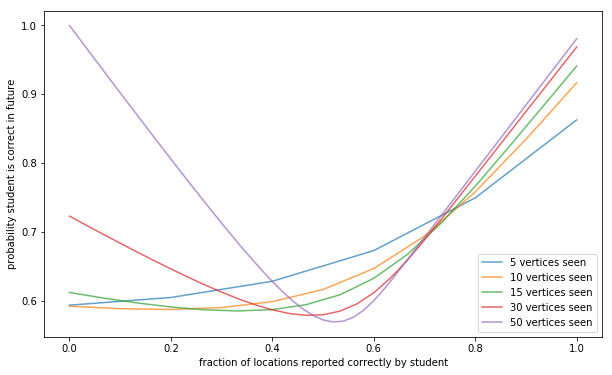

In [404]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 6) / 5, p_C_given_skn[5][0:6], label='5 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 11) / 10, p_C_given_skn[10][0:11], label='10 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 16) / 15, p_C_given_skn[15][0:16], label='15 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 21) / 20, p_C_given_skn[20][0:21], label='20 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 31) / 30, p_C_given_skn[30][0:31], label='30 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 41) / 40, p_C_given_skn[40][0:41], label='40 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 51) / 50, p_C_given_skn[50][0:51], label='50 vertices seen', alpha=0.7)
plt.legend()
plt.xlabel("fraction of locations reported correctly by student")
plt.ylabel("probability student is correct in future")
plt.show()

It's cool to note that with more vertices seen, we trust students who are very incorrect -- why? Well, if the graph was infinite, then we have no reason to do this. But because we have a limited number of vertices the students can be correct on, we need to adjust for the fact that there's not much more they _can_ be correct on, and this gets worse and worse with more vertices seen. However, this effect is counteracted when a student has been very right, regardless of how many vertices we've seen!

We can compare this with what happens when there's no gaurantee that $K \geq 50$ for any student, i.e. student correctness can truly vary to be any set.


In [398]:
p_C_given_skn_full_uniform = compute_all_p_C_given_skn(full_uniform_on_K)

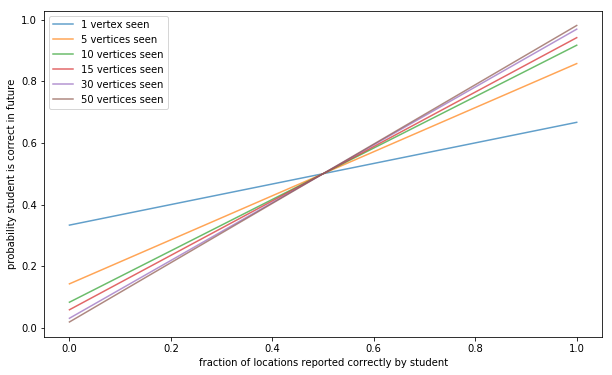

In [406]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 2) / 1, p_C_given_skn_full_uniform[1][0:2], label='1 vertex seen', alpha=0.7)
plt.plot(np.arange(0, 6) / 5, p_C_given_skn_full_uniform[5][0:6], label='5 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 11) / 10, p_C_given_skn_full_uniform[10][0:11], label='10 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 16) / 15, p_C_given_skn_full_uniform[15][0:16], label='15 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 21) / 20, p_C_given_skn[20][0:21], label='20 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 31) / 30, p_C_given_skn_full_uniform[30][0:31], label='30 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 41) / 40, p_C_given_skn[40][0:41], label='40 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 51) / 50, p_C_given_skn_full_uniform[50][0:51], label='50 vertices seen', alpha=0.7)
plt.legend()
plt.xlabel("fraction of locations reported correctly by student")
plt.ylabel("probability student is correct in future")
plt.show()

Now that there's no lower limit on how correct students are, it doesn't make sense to trust students who are very incorrect any more. They could just be as incorrect in the future. It's also cool to see how fast this fits on the number of vertices seen - Once we're at 5 vertices seen, having the student be incorrect for all of them means we think they'll be correct only 15% of the time in the future! This is a consequence of the Birthday paradox.

What happens with the true distribution we use, the beta distribution? Let's first estimate the discretized version of the Beta distribution:

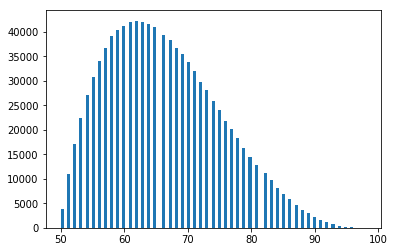

In [381]:
beta_no_samples = 1000000
b = 1 - (np.random.beta(4, 2, beta_no_samples))/2
beta_count = np.zeros(101)
beta_total = np.zeros(beta_no_samples)
for i in range(beta_no_samples):
    b_discrete = int(100 * b[i])
    beta_total[i] = b_discrete
    beta_count[b_discrete] += 1
beta_prob = beta_count / beta_no_samples

def beta_on_K(K):
    return beta_prob[K]

plt.hist(beta_total, bins=99)
plt.show()

Then we do the same thing again: estimate, for all possible states we have, the probability the student will be correct in the future.

In [391]:
p_C_given_skn_beta = compute_all_p_C_given_skn(beta_on_K)

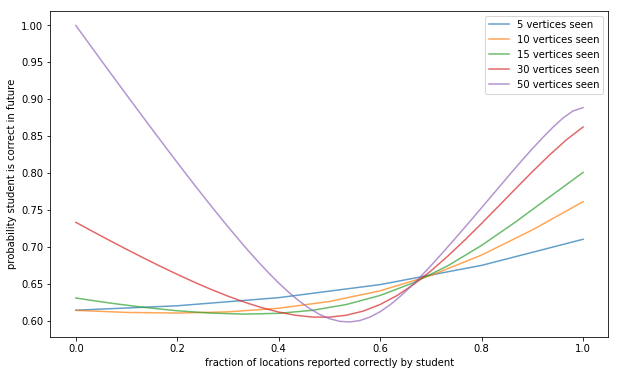

In [394]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 6) / 5, p_C_given_skn_beta[5][0:6], label='5 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 11) / 10, p_C_given_skn_beta[10][0:11], label='10 vertices seen', alpha=0.7)
plt.plot(np.arange(0, 16) / 15, p_C_given_skn_beta[15][0:16], label='15 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 21) / 20, p_C_given_skn[20][0:21], label='20 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 31) / 30, p_C_given_skn_beta[30][0:31], label='30 vertices seen', alpha=0.7)
# plt.plot(np.arange(0, 41) / 40, p_C_given_skn[40][0:41], label='40 vertices seen', alpha=0.5)
plt.plot(np.arange(0, 51) / 50, p_C_given_skn_beta[50][0:51], label='50 vertices seen', alpha=0.7)
plt.legend()
plt.xlabel("fraction of locations reported correctly by student")
plt.ylabel("probability student is correct in future")
plt.show()

There's not a tremendous difference, but we trust students who are very correct less compared to the uniform distribution. This makes sense, because the prior puts less weight on very correct students, so they are more rare.